The goal is to reproduce figures 3, 4 and 5 from this paper
http://incompleteideas.net/papers/sutton-88-with-erratum.pdf

# generating the training data:

In [1]:
# generate data
import random

import numpy as np

random.seed(42)

N_TRAIN_SETS = 100
N_SEQUENCES = 10

train_sets = []

for _ in range(N_TRAIN_SETS):
    
    train_set = []
    
    for _ in range(N_SEQUENCES):
        
        state = np.array([0, 0, 1, 0, 0])
        sequence = [state]
        
        # random walk
        while type(sequence[-1]) is not int:
            move_right = random.randint(0, 1)
            if move_right:
                state = np.roll(state, 1)
                if np.nonzero(state)[0][0] == 0:
                    state = 1
            else:
                state = np.roll(state, -1)
                if np.nonzero(state)[0][0] == 4:
                    state = 0
            sequence.append(state)
        
        train_set.append(sequence)
    
    train_sets.append(train_set)

# single example
train_sets[0][0]

[array([0, 0, 1, 0, 0]),
 array([0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0]),
 0]

# Replicating figure 3:

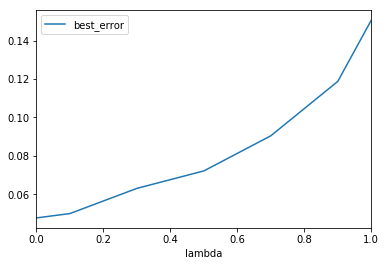

In [2]:
# replicate figure 3
import pandas as pd
%matplotlib inline

lambdas = [0, .1, .3, .5, .7, .9, 1.0]
learning_rates = [.001, .01, .1, .15, .2, .25, .3]
true_probabilities = np.array([1/6, 1/3, 1/2, 2/3, 5/6])


# if |max weight update| < this, we've converged
converged_thresh = .01 

# results[lambda_value][alpha_value][train_set_index] -> RMSE
results = {}

# store weight updates
weight_history = []

for lambda_ in lambdas:
    results[lambda_] = {}
    for alpha in learning_rates:
        #print(f'new model: lambda = {lambda_}, alpha = {alpha}')
        weights = np.zeros(5) * .5 # initialize to .5
  
        if alpha not in results[lambda_]:
            results[lambda_][alpha] = []
        
        for train_set_i, train_set in enumerate(train_sets): 
            
            accumulated_delta_weights = None
            iteration_count = 0
            
            while accumulated_delta_weights is None or np.amax(abs(accumulated_delta_weights)) > converged_thresh:

                # first iteration
                if accumulated_delta_weights is None:
                    accumulated_delta_weights = np.zeros(5)

                # non-converged iterations
                else:
                    weight_history.append(str(weights))
                    weights += accumulated_delta_weights # update weights
                    accumulated_delta_weights = np.zeros(5)
                    
                iteration_count += 1
                
                # if a weight exceeds 1.0/-1.0 we don't update accumulated_delta_weights & exit the while loop
                if np.amax(abs(weights)) < 1.0:
                    
                    # compute next weight update
                    for train_example_i, train_example in enumerate(train_set):              
                        # compute predictions for each time step of this training example & append the label
                        predictions = [np.dot(weights.T, state) for state in train_example[:-1]]
                        predictions.append(train_example[-1])

                        # compute weight updates for each time step of this episode
                        this_train_example_delta_weights = []
                        for t, state in enumerate(train_example[:-1]):
                            td_error = alpha * (predictions[t+1] - predictions[t])
                            td_gradients = np.zeros(5)
                            for k in range(t + 1):
                                td_gradients += train_example[k] * pow(lambda_, t - k)

                            this_train_example_delta_weights.append(td_error * td_gradients)

                        for e in this_train_example_delta_weights:
                            accumulated_delta_weights += e
                        #accumulated_delta_weights += sum(this_train_example_delta_weights)
                    
            # weights have converged for this train_set, calculate final RMSE 
            # using true_probabilities and add it to the results dict
            train_set_errors = []
            
            for train_example in train_set:
                # predict as usual, but don't pad it with the label
                predictions = [np.dot(weights.T, state) for state in train_example[:-1]]
                
                # compute errors using true_probabilities
                train_example_errors = [
                    np.dot(weights.T, state) - 
                    np.dot(true_probabilities.T, state)
                    for i, state in enumerate(train_example[:-1])
                ]
                
                # square and divide
                train_example_errors = [pow(err, 2) / len(train_example_errors) for err in train_example_errors]
            
                # sum and square root
                train_example_rmse = pow(sum(train_example_errors), .5)
                train_set_errors.append(train_example_rmse)
                
                
            # store average RMSE across train_examples
            results[lambda_][alpha].append(sum(train_set_errors) / len(train_set_errors))
        
        # average out RMSE for each train set into one value in results[lambda_][alpha]
        results[lambda_][alpha] = sum(results[lambda_][alpha]) / len(results[lambda_][alpha])
        
df_raw = [] # rows of lambda, best_avg_rmse
for lambda_, lambda_results in results.items():
    df_raw.append([lambda_, min(lambda_results.values())])

figure_3_df = pd.DataFrame(data=df_raw, columns=['lambda', 'best_error'])
figure_3_df.plot.line(x='lambda', y='best_error')

this looks exactly like the erratum

# replicating figure 4

changes from last setup:
- each train set is presented once
- weight updates are performed after each sequence (episode)
- weights are initialized to .5 and reset after each train set

we calculate RMSE across a known combination of alpha/lambda values and plot them all

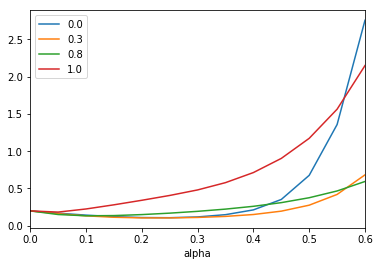

In [3]:
# replicate figure 4.
import matplotlib.pyplot as plt
lambdas = [0, .3, .8, 1.0]
learning_rates = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6]
true_probabilities = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
results = {}
weight_history = []

for lambda_ in lambdas:
    results[lambda_] = {}
    for alpha in learning_rates:
  
        if alpha not in results[lambda_]:
            results[lambda_][alpha] = []
        
        rmses = [] # rmse for each train_set
        
        for train_set_i, train_set in enumerate(train_sets):
            
            weights = np.ones(5) * .5
            train_set_rmses = [] # rmse for each training example
            
            # this time we iterate each train example once and update the weights right away
            for train_example_i, train_example in enumerate(train_set): 
                
                # compute predictions for each time step of this training example & append the label
                predictions = [np.dot(weights.T, state) for state in train_example[:-1]]
                predictions.append(train_example[-1])
                
                # compute weight updates for each time step of this episode
                this_train_example_delta_weights = []
                for t, state in enumerate(train_example[:-1]):
                    td_error = alpha * (predictions[t+1] - predictions[t])
                    td_gradients = np.zeros(5)
                    for k in range(t + 1):
                        td_gradients += train_example[k] * pow(lambda_, t - k)

                    this_train_example_delta_weights.append(td_error * td_gradients)

                # update weights right away
                for e in this_train_example_delta_weights:
                    weights += e
                
                # compute RMSE _after_ the weight update
                train_example_error = [
                    np.dot(weights.T, state) - 
                    np.dot(true_probabilities.T, state)
                    for i, state in enumerate(train_example[:-1])
                ]
                train_example_error = [pow(err, 2) / len(train_example_error) for err in train_example_error]
                train_set_rmses.append(pow(sum(train_example_error), .5))
                
            # average out rmses for this rain set and store
            rmses.append(sum(train_set_rmses) / len(train_set_rmses))
     
        # store final average error across train sets
        results[lambda_][alpha] = sum(rmses) / len(rmses)
        
df_raw = [] # rows of lambda, alpha, rmse
for lambda_, lambda_results in results.items():
    for alpha, rmse in lambda_results.items():
        df_raw.append([lambda_, alpha, rmse])

figure_4_df = pd.DataFrame(data=df_raw, columns=['lambda', 'alpha', 'error'])

fig, ax = plt.subplots()

for key, grp in figure_4_df.groupby(['lambda']):
    ax = grp.plot(ax=ax, kind='line', x='alpha', y='error', label=key)

plt.legend(loc='best')
plt.show()

# replicating figure 5

the setup is the same as figure 4, but instead of plotting every alpha/lambda combination we use the best alpha for each lambda.

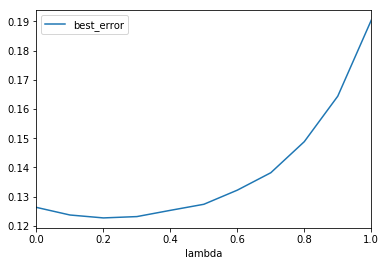

In [4]:
# replicate figure 5. attempt v1.
lambdas = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
learning_rates = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6]
true_probabilities = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
converged_thresh = .1 
results = {}
weight_history = []

for lambda_ in lambdas:
    results[lambda_] = {}
    for alpha in learning_rates:
  
        if alpha not in results[lambda_]:
            results[lambda_][alpha] = []
        
        rmses = [] # rmse for each train_set
        
        for train_set_i, train_set in enumerate(train_sets): 
            weights = np.ones(5) * .5
            train_set_rmses = [] 
            
            # this time we iterate each train example once and update the weights right away
            for train_example_i, train_example in enumerate(train_set): 
                
                # compute predictions for each time step of this training example & append the label
                predictions = [np.dot(weights.T, state) for state in train_example[:-1]]
                predictions.append(train_example[-1])
                
                # compute RMSE on this training example and add it to train_set_rmses
                train_example_error = [
                    np.dot(weights.T, state) - 
                    np.dot(true_probabilities.T, state)
                    for i, state in enumerate(train_example[:-1])
                ]
                train_example_error = [pow(err, 2) / len(train_example_error) for err in train_example_error]
                train_set_rmses.append(pow(sum(train_example_error), .5))
                
                # compute weight updates for each time step of this episode
                this_train_example_delta_weights = []
                for t, state in enumerate(train_example[:-1]):
                    td_error = alpha * (predictions[t+1] - predictions[t])
                    td_gradients = np.zeros(5)
                    for k in range(t + 1):
                        td_gradients += train_example[k] * pow(lambda_, t - k)

                    this_train_example_delta_weights.append(td_error * td_gradients)

                # update weights right away
                for e in this_train_example_delta_weights:
                    weights += e

            # average out rmses for this rain set and store
            rmses.append(sum(train_set_rmses) / len(train_set_rmses))
     
        # store final average error 
        results[lambda_][alpha] = sum(rmses) / len(rmses)
        
df_raw = [] # rows of lambda, best rmse
for lambda_, lambda_results in results.items():
    df_raw.append([lambda_, min(lambda_results.values())])

figure_5_df = pd.DataFrame(data=df_raw, columns=['lambda', 'best_error'])
figure_5_df.plot.line(x='lambda', y='best_error')